In [2]:
import os
import random

import cv2
import albumentations as A
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange

import time


In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA GeForce RTX 4080 SUPER


In [4]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

True
cuda


In [5]:
# randomness 제어를 위한 시드 고정 (학습 결과 재현을 위해 고정)
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()


# 시드 값 선택
SEED = 42
set_seed(SEED)

# 학습 장치 결정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
##### tqdm 사용법 #####
import time

# trange
for i in trange(100):
    time.sleep(0.01)

# tqdm
for _ in tqdm(list(range(100))): 
    time.sleep(0.01)
    
# iterable 객체는 모두 사용 가능, zip()이나 enumerate()와 같이 __len__()이 없는 경우 total=len(a)와 같이 명시
for _ in tqdm(zip(list(range(100)), list(range(100))), total=len(range(100))):
    time.sleep(0.01)

# 이중 반복문에서 사용
for _ in tqdm(list(range(5))):
    for _ in tqdm(list(range(100))):
        time.sleep(0.01)

100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


## Data Preprocessing

In [7]:
# 경로 설정 (로컬 환경인 경우 자신의 경로로 설정)
root_dir = 'C:/sg0117/hallym/2024-dl-final/'
save_dir = "C:/sg0117/hallym/2024-dl-final/save_data/"

train_dir = root_dir + 'train/'
train_w2v_dir = root_dir + 'train_w2v/'
test_dir = root_dir + 'test/'
test_w2v_dir = root_dir + 'test_w2v/'

In [8]:
train_df = pd.read_csv(root_dir + 'train.csv')
test_df = pd.read_csv(root_dir + 'test.csv')

In [9]:
train_df.head(5)

,id,path,w2v_path,title,year,genres
0,13,/kaggle/input/2024-dl-final/train/13.jpg,/kaggle/input/2024-dl-final/train_w2v/13.npy,Forrest Gump,1994,"['Comedy', 'Drama', 'Romance']"
1,55,/kaggle/input/2024-dl-final/train/55.jpg,/kaggle/input/2024-dl-final/train_w2v/55.npy,Amores Perros,2000,"['Drama', 'Thriller']"
2,64,/kaggle/input/2024-dl-final/train/64.jpg,/kaggle/input/2024-dl-final/train_w2v/64.npy,Talk to Her,2002,"['Drama', 'Romance']"
3,80,/kaggle/input/2024-dl-final/train/80.jpg,/kaggle/input/2024-dl-final/train_w2v/80.npy,Before Sunset,2004,"['Drama', 'Romance']"
4,86,/kaggle/input/2024-dl-final/train/86.jpg,/kaggle/input/2024-dl-final/train_w2v/86.npy,The Elementary Particles,2006,"['Drama', 'Romance']"


In [10]:
test_df.head(5)

,id,path,w2v_path,title,year
0,32,/kaggle/input/2024-dl-final/test/32.jpg,/kaggle/input/2024-dl-final/test_w2v/32.npy,Cannon Fodder,1995
1,91,/kaggle/input/2024-dl-final/test/91.jpg,/kaggle/input/2024-dl-final/test_w2v/91.npy,Land Without Bread,1933
2,114,/kaggle/input/2024-dl-final/test/114.jpg,/kaggle/input/2024-dl-final/test_w2v/114.npy,Pretty Woman,1990
3,142,/kaggle/input/2024-dl-final/test/142.jpg,/kaggle/input/2024-dl-final/test_w2v/142.npy,Brokeback Mountain,2005
4,156,/kaggle/input/2024-dl-final/test/156.jpg,/kaggle/input/2024-dl-final/test_w2v/156.npy,Wilbur Wants to Kill Himself,2002


In [11]:
# str -> list 변환 ("['Romance', 'Action', ...]" -> ['Romance', 'Action', ...])
train_df['genres'] = train_df['genres'].apply(lambda x: eval(x))

# multi label encoding
mlb = MultiLabelBinarizer()
train_label = mlb.fit_transform(train_df['genres'])

# column 순서 확인
mlb.classes_

array(['Action', 'Animation', 'Comedy', 'Documentary', 'Drama', 'Horror',
       'Romance', 'Thriller'], dtype=object)

In [12]:
# 기존 데이터와 결합
mlb_train = pd.DataFrame(train_label, columns=mlb.classes_)

train_df = pd.concat([train_df, mlb_train], axis=1)
train_df.head()

,id,path,w2v_path,title,year,genres,Action,Animation,Comedy,Documentary,Drama,Horror,Romance,Thriller
0,13,/kaggle/input/2024-dl-final/train/13.jpg,/kaggle/input/2024-dl-final/train_w2v/13.npy,Forrest Gump,1994,"[Comedy, Drama, Romance]",0,0,1,0,1,0,1,0
1,55,/kaggle/input/2024-dl-final/train/55.jpg,/kaggle/input/2024-dl-final/train_w2v/55.npy,Amores Perros,2000,"[Drama, Thriller]",0,0,0,0,1,0,0,1
2,64,/kaggle/input/2024-dl-final/train/64.jpg,/kaggle/input/2024-dl-final/train_w2v/64.npy,Talk to Her,2002,"[Drama, Romance]",0,0,0,0,1,0,1,0
3,80,/kaggle/input/2024-dl-final/train/80.jpg,/kaggle/input/2024-dl-final/train_w2v/80.npy,Before Sunset,2004,"[Drama, Romance]",0,0,0,0,1,0,1,0
4,86,/kaggle/input/2024-dl-final/train/86.jpg,/kaggle/input/2024-dl-final/train_w2v/86.npy,The Elementary Particles,2006,"[Drama, Romance]",0,0,0,0,1,0,1,0


In [13]:
# 로컬 환경에서 학습하는 경우
train_df['path'] = train_df['path'].apply(lambda x: train_dir + x.split('/')[-1])
test_df['path'] = test_df['path'].apply(lambda x: test_dir + x.split('/')[-1])
train_df['w2v_path'] = train_df['w2v_path'].apply(lambda x: train_w2v_dir + x.split('/')[-1])
test_df['w2v_path'] = test_df['w2v_path'].apply(lambda x: test_w2v_dir + x.split('/')[-1])

In [14]:
print(train_df.head(5))
print(test_df.head(5))

   id                                         path  \
0  13  C:/sg0117/hallym/2024-dl-final/train/13.jpg   
1  55  C:/sg0117/hallym/2024-dl-final/train/55.jpg   
2  64  C:/sg0117/hallym/2024-dl-final/train/64.jpg   
3  80  C:/sg0117/hallym/2024-dl-final/train/80.jpg   
4  86  C:/sg0117/hallym/2024-dl-final/train/86.jpg   

                                          w2v_path                     title  \
0  C:/sg0117/hallym/2024-dl-final/train_w2v/13.npy              Forrest Gump   
1  C:/sg0117/hallym/2024-dl-final/train_w2v/55.npy             Amores Perros   
2  C:/sg0117/hallym/2024-dl-final/train_w2v/64.npy               Talk to Her   
3  C:/sg0117/hallym/2024-dl-final/train_w2v/80.npy             Before Sunset   
4  C:/sg0117/hallym/2024-dl-final/train_w2v/86.npy  The Elementary Particles   

   year                    genres  Action  Animation  Comedy  Documentary  \
0  1994  [Comedy, Drama, Romance]       0          0       1            0   
1  2000         [Drama, Thriller]       

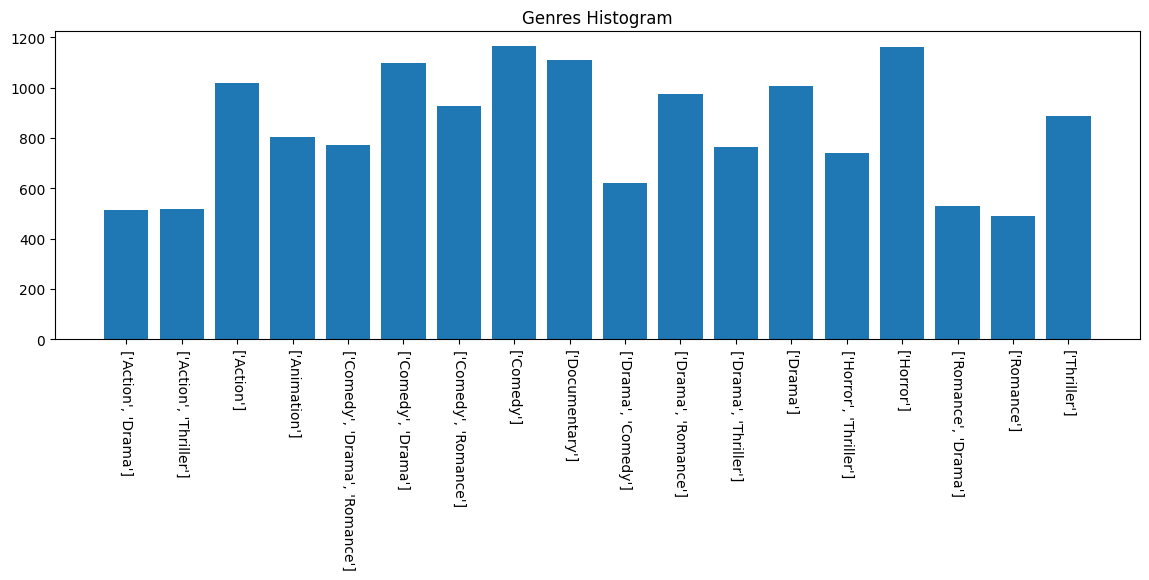

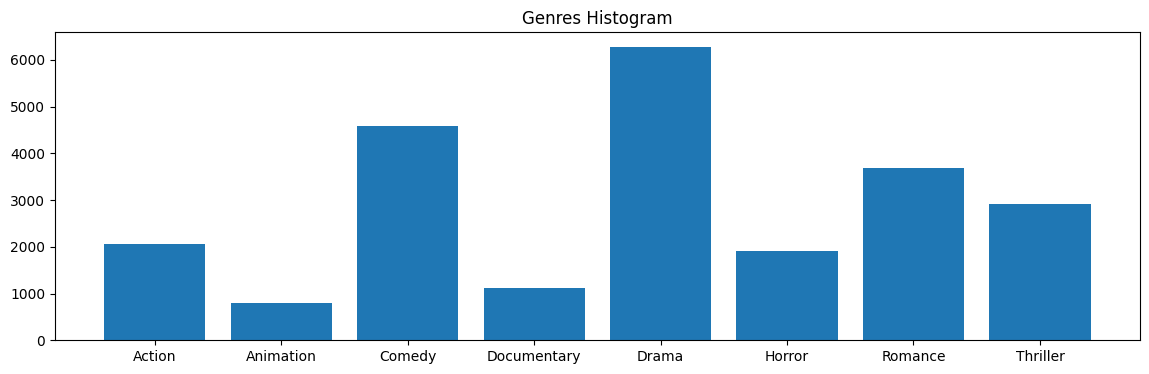

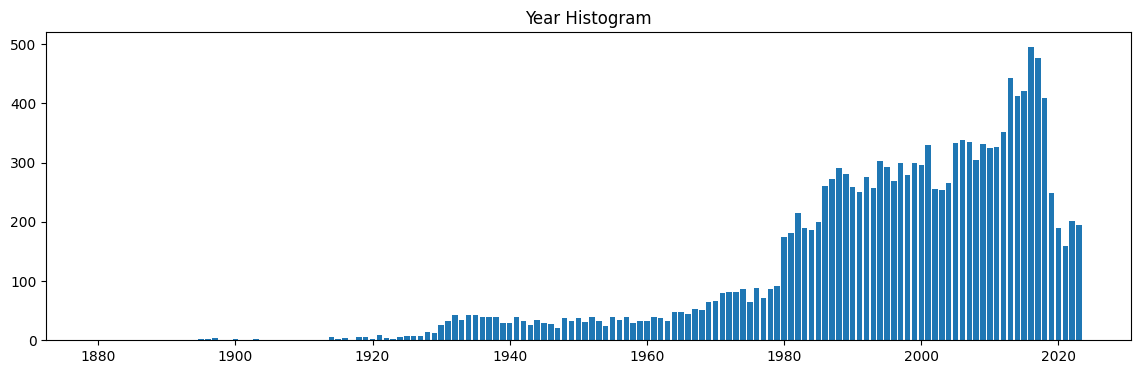

In [15]:
# multi-label을 하나의 class로 보는 경우의 히스토그램
tr_hist = train_df['genres'].apply(lambda x: str(x)).sort_values()
plt.figure(figsize=(14, 4))
plt.bar(tr_hist.unique(), tr_hist.value_counts().sort_index())
plt.xticks(rotation=-90)
plt.title('Genres Histogram')
plt.show()

# single-label을 하나의 class로 보는 경우의 히스토그램
mlb_hist = mlb_train.sum(axis=0)
plt.figure(figsize=(14, 4))
plt.bar(mlb.classes_, mlb_hist)
plt.title('Genres Histogram')
plt.show()


# 연도별 영화 히스토그램
plt.figure(figsize=(14, 4))
plt.bar(train_df['year'].sort_values().unique(), train_df['year'].value_counts().sort_index())
plt.title('Year Histogram')
plt.show()

## Dataset & Dataloader

In [16]:
class MovieDataset(Dataset):
    def __init__(self, df, transform=None, mode='train'):
        self.df = df
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 이미지 로드 BGR을 RGB 순서로 바꿈. opencv는 BGR 형식을 사용하기 때문에 pytorch를 위해 RGB로 바꿔줌.
        image = cv2.cvtColor(cv2.imread(self.df.iloc[idx, 1]), cv2.COLOR_BGR2RGB)
        # word를 벡터로 임베딩함
        w2v = torch.Tensor(np.load(self.df.iloc[idx, 2]))

        if self.transform:
            # 이미ㅣㅈ transform 적용
            augmented = self.transform(image=image)
            image = augmented['image']
        else:
            # 이미지 transform 적용 안할경우 그냥 텐서변환 (test 셋에서 사용)
            image = A.ToTensorV2()(image=image)

        # train 셋인 경우 레이블도 반환함
        if self.mode == 'train':
            # 라벨 텐서변환
            label = torch.Tensor(self.df.iloc[idx, 6:].to_numpy(dtype=np.float32))
            return image, w2v, label

        return image, w2v

In [17]:
# train_transform = A.Compose([
#     # https://albumentations.ai/docs/api_reference/full_reference/
#     A.Resize(128, 128),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.5), # 랜덤 밝기 대비
#     A.RandomResizedCrop(height=128, width=128, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5), # 랜덤크롭
#     A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=30, p=0.5),  # 이동, 확대/축소, 회전
#     A.CoarseDropout(max_holes=4, max_height=16, max_width=16, min_height=8, min_width=8, fill_value=0, p=0.5), # 랜덤으로 빵꾸 뚫기
#     A.Normalize(),
#     ToTensorV2()
# ])

# test_transform = A.Compose([
#     A.Resize(128, 128),

#     A.Normalize(),
#     ToTensorV2()
# ])

# 241214 오후 10시 16분 데이터 증강 기법 더 추가

In [18]:
train_transform = A.Compose([
    # https://albumentations.ai/docs/api_reference/full_reference/
    A.Resize(128, 128),             # 이미지 크기 조정  
    A.HorizontalFlip(p=0.5),        # 좌우 반전
    A.RandomBrightnessContrast(p=0.7), # 랜덤 밝기 대비
    A.RandomResizedCrop(height=128, width=128, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5), # 랜덤크롭 
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=30, p=0.7),  # 이동, 확대/축소, 회전
    A.CoarseDropout(max_holes=4, max_height=16, max_width=16, min_height=8, min_width=8, fill_value=0, p=0.8), # 랜덤으로 빵꾸 뚫기
    A.Normalize(), 
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(128, 128),

    A.Normalize(),
    ToTensorV2()
])

In [19]:
import os

num_workers = os.cpu_count()
print(num_workers)


12


train loop에서 k_fold를 적용하여 train/validation 데이터 로더를 새로 작성하였기 때문에 해당 부분은 주석처리 해놓았습니다.

In [20]:
batch_size = 32
# batch_size = 16
# batch_size = 10
num_workers = 0  # 로컬에서 설정하면 학습 루프 안돌아감 ㅜㅜ

# train/validation 분리
# train_df, val_df = train_test_split(train_df, test_size=0.1, shuffle=True, random_state=SEED,
#                                     stratify=train_df['genres'])

# train_dataset = MovieDataset(df=train_df, transform=train_transform)
# val_dataset = MovieDataset(df=val_df, transform=test_transform)
test_dataset = MovieDataset(df=test_df, transform=test_transform, mode='test')

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers)

# train_dataset.__len__(), val_dataset.__len__(), 
test_dataset.__len__()

5034

In [21]:
imgs = []
for i in range(10):
    img, _, _ = train_dataset.__getitem__(i)  # transform이 적용된 이미지 반환
    img = img.permute((1, 2, 0)).float()
    imgs.append(img.numpy())  # (3, 128, 128) 형태의 image를 (128, 128, 3) 형태로 바꿔서 저장

fig = plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs[i])

plt.show()

NameError: name 'train_dataset' is not defined

## Model

In [ ]:
class MovieClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(MovieClassifier, self).__init__()
        self.num_classes = num_classes

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # 3x224x224 -> 32x224x224
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x224x224 -> 32x112x112

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 32x112x112 -> 64x112x112
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64x112x112 -> 64x56x56

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  # 64x56x56 -> 64x56x56
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64x56x56 -> 64x28x28

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # 64x28x28 -> 128x28x28
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128x28x28 -> 128x14x14

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)  # 128x14x14 -> 128x14x14
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128x14x14 -> 128x7x7

        # 글로벌 Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)  # 128x7x7 -> 128x1x1

        # Word2Vec Fully Connected Layer
        self.word2vec_fc = nn.Sequential(
            nn.Linear(15 * 300, 128),  # 15x300 Word2Vec -> 128
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5)
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(128 + 128, 128),  # Image Features (128) + Word2Vec Features (128)
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)  # Output: num_classes
        )

    def forward(self, image, w2v):
        # CNN Path for Image Features
        x1 = F.relu(self.conv1(image))
        x1 = self.pool1(x1)
        x1 = F.relu(self.conv2(x1))
        x1 = self.pool2(x1)
        x1 = F.relu(self.conv3(x1))
        x1 = self.pool3(x1)
        x1 = F.relu(self.conv4(x1))
        x1 = self.pool4(x1)
        x1 = F.relu(self.conv5(x1))
        x1 = self.pool5(x1)
        x1 = self.gap(x1)  # Global Average Pooling
        x1 = torch.flatten(x1, 1)

        # Word2Vec Path
        x2 = self.word2vec_fc(w2v.view(w2v.size(0), -1))

        # Concatenate Image and Word2Vec Features
        x = torch.cat((x1, x2), dim=1)

        # Fully Connected Layers
        x = self.fc(x)
        return x


In [50]:
num_classes = mlb.classes_.shape[0]

# 모델 초기화
model = MovieClassifier(num_classes=num_classes).to(device)

## Loss & Optimizer

In [51]:
# criterion = nn.BCELoss()
#https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

## Train & Validation

In [52]:
# TODO: train code 241203 w2v도 for문 돌려야됨

def train(model, train_loader, criterion, optimizer, device):
    # print("데이터 로딩 시작")   # 디버깅용 출력
    model.train()   # 모델을 학습모드로 설정
    total_loss = 0  # 총 loss 저장
    all_pred = []  # 모델 예측값 저장
    all_label = [] # 실제 라벨 저장

    for images, w2v, labels in tqdm(train_loader, desc="Training"):
        # print("배치 처리 중")
        # 데이터 쿠다로 보냄
        images, w2v, labels = images.to(device), w2v.to(device), labels.to(device)

        # Forward pass
        outputs = model(images, w2v)  # 모델에 이미지와 word2Vec 입력
        loss = criterion(outputs, labels)  # 예측값과 실제라벨을 비교하여 손실값 계산
        # print("손실 계산 완료")
        
        optimizer.zero_grad()   # 기울기 초기화
        loss.backward() # loss 값을 기준으로 gradient 계산
        optimizer.step() # 가중치 업데이트

        total_loss += loss.item() 
        all_pred.append(torch.sigmoid(outputs).detach().cpu())  # 예측값을 sigmoid로 적용해 확률값으로 변환. cpu로 보내기
        all_label.append(labels.detach().cpu())  # 실제라벨을 cpu로 보내기

    # 평균 손실 계산
    avg_loss = total_loss / len(train_loader)
    all_pred = torch.cat(all_pred)
    all_label = torch.cat(all_label)
    return avg_loss, all_pred, all_label

In [53]:
# TODO: validation code
def validate(model, val_loader, criterion, device):
    model.eval()  # 모델을 평가 모드로 설정 (dropout, batchNorm 끔)
    total_loss = 0
    all_pred = []
    all_label = []

    with torch.no_grad():   # 평가 모드에서 기울기 계산 끔
        for images, w2v, labels in tqdm(val_loader, desc="Validation"):
            images, w2v, labels = images.to(device), w2v.to(device), labels.to(device)

            # Forward pass
            outputs = model(images, w2v)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_pred.append(torch.sigmoid(outputs).detach().cpu())  # Sigmoid로 확률 값 계산
            all_label.append(labels.detach().cpu())

    # 평균 손실 계산
    avg_loss = total_loss / len(val_loader)
    all_pred = torch.cat(all_pred)
    all_label = torch.cat(all_label)
    return avg_loss, all_pred, all_label

## Loss 분석


Fold 1/8 시작...
13219 1882
Epoch 1/10 - Fold 1


Training: 100%|██████████| 265/265 [00:25<00:00, 10.24it/s]


Train Loss: 0.6840, Train Accuracy: 0.3815


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.94it/s]


Validation Loss: 0.6554, Validation Accuracy: 0.2912
##########  Best Loss Model saved with loss: 0.6554  ##########
##########  Best Loss Model saved checkpoin: 0.6554  ##########
##########  Best Accuracy Model saved with accuracy: 0.2912  ##########
Epoch 2/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.76it/s]


Train Loss: 0.6418, Train Accuracy: 0.4527


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.58it/s]


Validation Loss: 0.6148, Validation Accuracy: 0.4337
##########  Best Loss Model saved with loss: 0.6148  ##########
##########  Best Loss Model saved checkpoin: 0.6148  ##########
##########  Best Accuracy Model saved with accuracy: 0.4337  ##########
Epoch 3/10 - Fold 1


Training: 100%|██████████| 265/265 [00:25<00:00, 10.53it/s]


Train Loss: 0.6090, Train Accuracy: 0.5182


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.59it/s]


Validation Loss: 0.5868, Validation Accuracy: 0.5156
##########  Best Loss Model saved with loss: 0.5868  ##########
##########  Best Loss Model saved checkpoin: 0.5868  ##########
##########  Best Accuracy Model saved with accuracy: 0.5156  ##########
Epoch 4/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.72it/s]


Train Loss: 0.5830, Train Accuracy: 0.5659


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.03it/s]


Validation Loss: 0.5615, Validation Accuracy: 0.5807
##########  Best Loss Model saved with loss: 0.5615  ##########
##########  Best Loss Model saved checkpoin: 0.5615  ##########
##########  Best Accuracy Model saved with accuracy: 0.5807  ##########
Epoch 5/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.80it/s]


Train Loss: 0.5594, Train Accuracy: 0.6086


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.02it/s]


Validation Loss: 0.5383, Validation Accuracy: 0.6394
##########  Best Loss Model saved with loss: 0.5383  ##########
##########  Best Loss Model saved checkpoin: 0.5383  ##########
##########  Best Accuracy Model saved with accuracy: 0.6394  ##########
Epoch 6/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.68it/s]


Train Loss: 0.5410, Train Accuracy: 0.6445


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.18it/s]


Validation Loss: 0.5203, Validation Accuracy: 0.6846
##########  Best Loss Model saved with loss: 0.5203  ##########
##########  Best Loss Model saved checkpoin: 0.5203  ##########
##########  Best Accuracy Model saved with accuracy: 0.6846  ##########
Epoch 7/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.73it/s]


Train Loss: 0.5234, Train Accuracy: 0.6780


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.68it/s]


Validation Loss: 0.5049, Validation Accuracy: 0.7181
##########  Best Loss Model saved with loss: 0.5049  ##########
##########  Best Loss Model saved checkpoin: 0.5049  ##########
##########  Best Accuracy Model saved with accuracy: 0.7181  ##########
Epoch 8/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.68it/s]


Train Loss: 0.5087, Train Accuracy: 0.7064


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.36it/s]


Validation Loss: 0.4913, Validation Accuracy: 0.7448
##########  Best Loss Model saved with loss: 0.4913  ##########
##########  Best Loss Model saved checkpoin: 0.4913  ##########
##########  Best Accuracy Model saved with accuracy: 0.7448  ##########
Epoch 9/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.88it/s]


Train Loss: 0.4952, Train Accuracy: 0.7275


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.82it/s]


Validation Loss: 0.4819, Validation Accuracy: 0.7575
##########  Best Loss Model saved with loss: 0.4819  ##########
##########  Best Loss Model saved checkpoin: 0.4819  ##########
##########  Best Accuracy Model saved with accuracy: 0.7575  ##########
Epoch 10/10 - Fold 1


Training: 100%|██████████| 265/265 [00:24<00:00, 10.91it/s]


Train Loss: 0.4841, Train Accuracy: 0.7449


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.89it/s]


Validation Loss: 0.4712, Validation Accuracy: 0.7694
##########  Best Loss Model saved with loss: 0.4712  ##########
##########  Best Loss Model saved checkpoin: 0.4712  ##########
##########  Best Accuracy Model saved with accuracy: 0.7694  ##########

Fold 2/8 시작...
13190 1911
Epoch 1/10 - Fold 2


Training: 100%|██████████| 264/264 [00:25<00:00, 10.51it/s]


Train Loss: 0.4756, Train Accuracy: 0.7571


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.02it/s]


Validation Loss: 0.4619, Validation Accuracy: 0.7823
##########  Best Loss Model saved with loss: 0.4619  ##########
##########  Best Loss Model saved checkpoin: 0.4619  ##########
##########  Best Accuracy Model saved with accuracy: 0.7823  ##########
Epoch 2/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.71it/s]


Train Loss: 0.4663, Train Accuracy: 0.7682


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.98it/s]


Validation Loss: 0.4536, Validation Accuracy: 0.7889
##########  Best Loss Model saved with loss: 0.4536  ##########
##########  Best Loss Model saved checkpoin: 0.4536  ##########
##########  Best Accuracy Model saved with accuracy: 0.7889  ##########
Epoch 3/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.75it/s]


Train Loss: 0.4594, Train Accuracy: 0.7750


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.73it/s]


Validation Loss: 0.4471, Validation Accuracy: 0.7928
##########  Best Loss Model saved with loss: 0.4471  ##########
##########  Best Loss Model saved checkpoin: 0.4471  ##########
##########  Best Accuracy Model saved with accuracy: 0.7928  ##########
Epoch 4/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.61it/s]


Train Loss: 0.4538, Train Accuracy: 0.7807


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]


Validation Loss: 0.4426, Validation Accuracy: 0.7970
##########  Best Loss Model saved with loss: 0.4426  ##########
##########  Best Loss Model saved checkpoin: 0.4426  ##########
##########  Best Accuracy Model saved with accuracy: 0.7970  ##########
Epoch 5/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.68it/s]


Train Loss: 0.4464, Train Accuracy: 0.7872


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.45it/s]


Validation Loss: 0.4356, Validation Accuracy: 0.8009
##########  Best Loss Model saved with loss: 0.4356  ##########
##########  Best Loss Model saved checkpoin: 0.4356  ##########
##########  Best Accuracy Model saved with accuracy: 0.8009  ##########
Epoch 6/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.77it/s]


Train Loss: 0.4416, Train Accuracy: 0.7899


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.38it/s]


Validation Loss: 0.4319, Validation Accuracy: 0.7976
##########  Best Loss Model saved with loss: 0.4319  ##########
##########  Best Loss Model saved checkpoin: 0.4319  ##########
Epoch 7/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.59it/s]


Train Loss: 0.4359, Train Accuracy: 0.7944


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.33it/s]


Validation Loss: 0.4272, Validation Accuracy: 0.8013
##########  Best Loss Model saved with loss: 0.4272  ##########
##########  Best Loss Model saved checkpoin: 0.4272  ##########
##########  Best Accuracy Model saved with accuracy: 0.8013  ##########
Epoch 8/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.64it/s]


Train Loss: 0.4323, Train Accuracy: 0.7952


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.98it/s]


Validation Loss: 0.4237, Validation Accuracy: 0.7998
##########  Best Loss Model saved with loss: 0.4237  ##########
##########  Best Loss Model saved checkpoin: 0.4237  ##########
Epoch 9/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.69it/s]


Train Loss: 0.4267, Train Accuracy: 0.7996


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]


Validation Loss: 0.4195, Validation Accuracy: 0.8066
##########  Best Loss Model saved with loss: 0.4195  ##########
##########  Best Loss Model saved checkpoin: 0.4195  ##########
##########  Best Accuracy Model saved with accuracy: 0.8066  ##########
Epoch 10/10 - Fold 2


Training: 100%|██████████| 264/264 [00:24<00:00, 10.57it/s]


Train Loss: 0.4233, Train Accuracy: 0.8018


Validation: 100%|██████████| 39/39 [00:03<00:00, 12.75it/s]


Validation Loss: 0.4179, Validation Accuracy: 0.8070
##########  Best Loss Model saved with loss: 0.4179  ##########
##########  Best Loss Model saved checkpoin: 0.4179  ##########
##########  Best Accuracy Model saved with accuracy: 0.8070  ##########

Fold 3/8 시작...
13190 1911
Epoch 1/10 - Fold 3


Training: 100%|██████████| 264/264 [00:24<00:00, 10.79it/s]


Train Loss: 0.4210, Train Accuracy: 0.8024


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.30it/s]


Validation Loss: 0.4028, Validation Accuracy: 0.8128
##########  Best Loss Model saved with loss: 0.4028  ##########
##########  Best Loss Model saved checkpoin: 0.4028  ##########
##########  Best Accuracy Model saved with accuracy: 0.8128  ##########
Epoch 2/10 - Fold 3


Training: 100%|██████████| 264/264 [00:24<00:00, 10.64it/s]


Train Loss: 0.4175, Train Accuracy: 0.8043


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.38it/s]


Validation Loss: 0.4011, Validation Accuracy: 0.8143
##########  Best Loss Model saved with loss: 0.4011  ##########
##########  Best Loss Model saved checkpoin: 0.4011  ##########
##########  Best Accuracy Model saved with accuracy: 0.8143  ##########
Epoch 3/10 - Fold 3


Training: 100%|██████████| 264/264 [00:24<00:00, 10.64it/s]


Train Loss: 0.4146, Train Accuracy: 0.8051


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.21it/s]


Validation Loss: 0.3991, Validation Accuracy: 0.8159
##########  Best Loss Model saved with loss: 0.3991  ##########
##########  Best Loss Model saved checkpoin: 0.3991  ##########
##########  Best Accuracy Model saved with accuracy: 0.8159  ##########
Epoch 4/10 - Fold 3


Training: 100%|██████████| 264/264 [00:25<00:00, 10.48it/s]


Train Loss: 0.4124, Train Accuracy: 0.8067


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.36it/s]


Validation Loss: 0.3955, Validation Accuracy: 0.8165
##########  Best Loss Model saved with loss: 0.3955  ##########
##########  Best Loss Model saved checkpoin: 0.3955  ##########
##########  Best Accuracy Model saved with accuracy: 0.8165  ##########
Epoch 5/10 - Fold 3


Training: 100%|██████████| 264/264 [00:24<00:00, 10.63it/s]


Train Loss: 0.4094, Train Accuracy: 0.8067


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.64it/s]


Validation Loss: 0.3937, Validation Accuracy: 0.8178
##########  Best Loss Model saved with loss: 0.3937  ##########
##########  Best Loss Model saved checkpoin: 0.3937  ##########
##########  Best Accuracy Model saved with accuracy: 0.8178  ##########
Epoch 6/10 - Fold 3


Training: 100%|██████████| 264/264 [00:24<00:00, 10.64it/s]


Train Loss: 0.4076, Train Accuracy: 0.8089


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.79it/s]


Validation Loss: 0.3904, Validation Accuracy: 0.8205
##########  Best Loss Model saved with loss: 0.3904  ##########
##########  Best Loss Model saved checkpoin: 0.3904  ##########
##########  Best Accuracy Model saved with accuracy: 0.8205  ##########
Epoch 7/10 - Fold 3


Training: 100%|██████████| 264/264 [00:24<00:00, 10.77it/s]


Train Loss: 0.4050, Train Accuracy: 0.8095


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.44it/s]


Validation Loss: 0.3887, Validation Accuracy: 0.8183
##########  Best Loss Model saved with loss: 0.3887  ##########
##########  Best Loss Model saved checkpoin: 0.3887  ##########
Epoch 8/10 - Fold 3


Training: 100%|██████████| 264/264 [00:24<00:00, 10.64it/s]


Train Loss: 0.4016, Train Accuracy: 0.8111


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.81it/s]


Validation Loss: 0.3878, Validation Accuracy: 0.8192
##########  Best Loss Model saved with loss: 0.3878  ##########
##########  Best Loss Model saved checkpoin: 0.3878  ##########
Epoch 9/10 - Fold 3


Training: 100%|██████████| 264/264 [01:42<00:00,  2.59it/s]


Train Loss: 0.4003, Train Accuracy: 0.8108


Validation: 100%|██████████| 39/39 [00:08<00:00,  4.34it/s]


Validation Loss: 0.3880, Validation Accuracy: 0.8225
##########  Best Accuracy Model saved with accuracy: 0.8225  ##########
Epoch 10/10 - Fold 3


Training: 100%|██████████| 264/264 [00:27<00:00,  9.65it/s]


Train Loss: 0.3984, Train Accuracy: 0.8125


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.97it/s]


Validation Loss: 0.3850, Validation Accuracy: 0.8179
##########  Best Loss Model saved with loss: 0.3850  ##########
##########  Best Loss Model saved checkpoin: 0.3850  ##########

Fold 4/8 시작...
13254 1847
Epoch 1/10 - Fold 4


Training: 100%|██████████| 266/266 [00:25<00:00, 10.49it/s]


Train Loss: 0.3974, Train Accuracy: 0.8118


Validation: 100%|██████████| 37/37 [00:02<00:00, 12.67it/s]


Validation Loss: 0.3778, Validation Accuracy: 0.8315
##########  Best Loss Model saved with loss: 0.3778  ##########
##########  Best Loss Model saved checkpoin: 0.3778  ##########
##########  Best Accuracy Model saved with accuracy: 0.8315  ##########
Epoch 2/10 - Fold 4


Training: 100%|██████████| 266/266 [00:24<00:00, 10.79it/s]


Train Loss: 0.3954, Train Accuracy: 0.8126


Validation: 100%|██████████| 37/37 [00:02<00:00, 13.56it/s]


Validation Loss: 0.3801, Validation Accuracy: 0.8300
Epoch 3/10 - Fold 4


Training: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]


Train Loss: 0.3938, Train Accuracy: 0.8149


Validation: 100%|██████████| 37/37 [00:02<00:00, 13.87it/s]


Validation Loss: 0.3773, Validation Accuracy: 0.8309
##########  Best Loss Model saved with loss: 0.3773  ##########
##########  Best Loss Model saved checkpoin: 0.3773  ##########
Epoch 4/10 - Fold 4


Training: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]


Train Loss: 0.3931, Train Accuracy: 0.8138


Validation: 100%|██████████| 37/37 [00:02<00:00, 14.01it/s]


Validation Loss: 0.3750, Validation Accuracy: 0.8311
##########  Best Loss Model saved with loss: 0.3750  ##########
##########  Best Loss Model saved checkpoin: 0.3750  ##########
Epoch 5/10 - Fold 4


Training: 100%|██████████| 266/266 [00:24<00:00, 10.79it/s]


Train Loss: 0.3902, Train Accuracy: 0.8147


Validation: 100%|██████████| 37/37 [00:02<00:00, 13.79it/s]


Validation Loss: 0.3746, Validation Accuracy: 0.8301
##########  Best Loss Model saved with loss: 0.3746  ##########
##########  Best Loss Model saved checkpoin: 0.3746  ##########
Epoch 6/10 - Fold 4


Training: 100%|██████████| 266/266 [00:24<00:00, 10.65it/s]


Train Loss: 0.3890, Train Accuracy: 0.8159


Validation: 100%|██████████| 37/37 [00:02<00:00, 13.69it/s]


Validation Loss: 0.3740, Validation Accuracy: 0.8286
##########  Best Loss Model saved with loss: 0.3740  ##########
##########  Best Loss Model saved checkpoin: 0.3740  ##########
Epoch 7/10 - Fold 4


Training: 100%|██████████| 266/266 [00:25<00:00, 10.64it/s]


Train Loss: 0.3877, Train Accuracy: 0.8167


Validation: 100%|██████████| 37/37 [00:02<00:00, 13.04it/s]


Validation Loss: 0.3736, Validation Accuracy: 0.8328
##########  Best Loss Model saved with loss: 0.3736  ##########
##########  Best Loss Model saved checkpoin: 0.3736  ##########
##########  Best Accuracy Model saved with accuracy: 0.8328  ##########
Epoch 8/10 - Fold 4


Training: 100%|██████████| 266/266 [00:25<00:00, 10.61it/s]


Train Loss: 0.3860, Train Accuracy: 0.8175


Validation: 100%|██████████| 37/37 [00:02<00:00, 13.97it/s]


Validation Loss: 0.3724, Validation Accuracy: 0.8307
##########  Best Loss Model saved with loss: 0.3724  ##########
##########  Best Loss Model saved checkpoin: 0.3724  ##########
Epoch 9/10 - Fold 4


Training: 100%|██████████| 266/266 [00:25<00:00, 10.64it/s]


Train Loss: 0.3841, Train Accuracy: 0.8204


Validation: 100%|██████████| 37/37 [00:02<00:00, 14.11it/s]


Validation Loss: 0.3718, Validation Accuracy: 0.8307
##########  Best Loss Model saved with loss: 0.3718  ##########
##########  Best Loss Model saved checkpoin: 0.3718  ##########
Epoch 10/10 - Fold 4


Training: 100%|██████████| 266/266 [00:24<00:00, 10.75it/s]


Train Loss: 0.3831, Train Accuracy: 0.8187


Validation: 100%|██████████| 37/37 [00:02<00:00, 13.84it/s]


Validation Loss: 0.3704, Validation Accuracy: 0.8303
##########  Best Loss Model saved with loss: 0.3704  ##########
##########  Best Loss Model saved checkpoin: 0.3704  ##########

Fold 5/8 시작...
13228 1873
Epoch 1/10 - Fold 5


Training: 100%|██████████| 265/265 [00:25<00:00, 10.51it/s]


Train Loss: 0.3844, Train Accuracy: 0.8188


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.73it/s]


Validation Loss: 0.3586, Validation Accuracy: 0.8398
##########  Best Loss Model saved with loss: 0.3586  ##########
##########  Best Loss Model saved checkpoin: 0.3586  ##########
##########  Best Accuracy Model saved with accuracy: 0.8398  ##########
Epoch 2/10 - Fold 5


Training: 100%|██████████| 265/265 [00:24<00:00, 10.64it/s]


Train Loss: 0.3826, Train Accuracy: 0.8180


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.39it/s]


Validation Loss: 0.3599, Validation Accuracy: 0.8383
Epoch 3/10 - Fold 5


Training: 100%|██████████| 265/265 [00:25<00:00, 10.42it/s]


Train Loss: 0.3814, Train Accuracy: 0.8186


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.32it/s]


Validation Loss: 0.3603, Validation Accuracy: 0.8395
Epoch 4/10 - Fold 5


Training: 100%|██████████| 265/265 [00:25<00:00, 10.38it/s]


Train Loss: 0.3801, Train Accuracy: 0.8209


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.14it/s]


Validation Loss: 0.3583, Validation Accuracy: 0.8404
##########  Best Loss Model saved with loss: 0.3583  ##########
##########  Best Loss Model saved checkpoin: 0.3583  ##########
##########  Best Accuracy Model saved with accuracy: 0.8404  ##########
Epoch 5/10 - Fold 5


Training: 100%|██████████| 265/265 [00:25<00:00, 10.56it/s]


Train Loss: 0.3794, Train Accuracy: 0.8203


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.85it/s]


Validation Loss: 0.3577, Validation Accuracy: 0.8386
##########  Best Loss Model saved with loss: 0.3577  ##########
##########  Best Loss Model saved checkpoin: 0.3577  ##########
Epoch 6/10 - Fold 5


Training: 100%|██████████| 265/265 [00:25<00:00, 10.55it/s]


Train Loss: 0.3772, Train Accuracy: 0.8213


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.01it/s]


Validation Loss: 0.3595, Validation Accuracy: 0.8403
Epoch 7/10 - Fold 5


Training: 100%|██████████| 265/265 [00:24<00:00, 10.64it/s]


Train Loss: 0.3761, Train Accuracy: 0.8212


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.74it/s]


Validation Loss: 0.3567, Validation Accuracy: 0.8400
##########  Best Loss Model saved with loss: 0.3567  ##########
##########  Best Loss Model saved checkpoin: 0.3567  ##########
Epoch 8/10 - Fold 5


Training: 100%|██████████| 265/265 [00:25<00:00, 10.48it/s]


Train Loss: 0.3745, Train Accuracy: 0.8225


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.29it/s]


Validation Loss: 0.3555, Validation Accuracy: 0.8393
##########  Best Loss Model saved with loss: 0.3555  ##########
##########  Best Loss Model saved checkpoin: 0.3555  ##########
Epoch 9/10 - Fold 5


Training: 100%|██████████| 265/265 [00:24<00:00, 10.73it/s]


Train Loss: 0.3737, Train Accuracy: 0.8226


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.13it/s]


Validation Loss: 0.3575, Validation Accuracy: 0.8414
##########  Best Accuracy Model saved with accuracy: 0.8414  ##########
Epoch 10/10 - Fold 5


Training: 100%|██████████| 265/265 [00:24<00:00, 10.65it/s]


Train Loss: 0.3736, Train Accuracy: 0.8228


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.83it/s]


Validation Loss: 0.3564, Validation Accuracy: 0.8410

Fold 6/8 시작...
13196 1905
Epoch 1/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.58it/s]


Train Loss: 0.3726, Train Accuracy: 0.8235


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.27it/s]


Validation Loss: 0.3460, Validation Accuracy: 0.8417
##########  Best Loss Model saved with loss: 0.3460  ##########
##########  Best Loss Model saved checkpoin: 0.3460  ##########
##########  Best Accuracy Model saved with accuracy: 0.8417  ##########
Epoch 2/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.62it/s]


Train Loss: 0.3727, Train Accuracy: 0.8231


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.85it/s]


Validation Loss: 0.3465, Validation Accuracy: 0.8409
Epoch 3/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.66it/s]


Train Loss: 0.3707, Train Accuracy: 0.8251


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.02it/s]


Validation Loss: 0.3458, Validation Accuracy: 0.8427
##########  Best Loss Model saved with loss: 0.3458  ##########
##########  Best Loss Model saved checkpoin: 0.3458  ##########
##########  Best Accuracy Model saved with accuracy: 0.8427  ##########
Epoch 4/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.71it/s]


Train Loss: 0.3700, Train Accuracy: 0.8250


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]


Validation Loss: 0.3451, Validation Accuracy: 0.8394
##########  Best Loss Model saved with loss: 0.3451  ##########
##########  Best Loss Model saved checkpoin: 0.3451  ##########
Epoch 5/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.70it/s]


Train Loss: 0.3691, Train Accuracy: 0.8248


Validation: 100%|██████████| 39/39 [00:02<00:00, 14.25it/s]


Validation Loss: 0.3456, Validation Accuracy: 0.8425
Epoch 6/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.70it/s]


Train Loss: 0.3688, Train Accuracy: 0.8248


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.35it/s]


Validation Loss: 0.3449, Validation Accuracy: 0.8409
##########  Best Loss Model saved with loss: 0.3449  ##########
##########  Best Loss Model saved checkpoin: 0.3449  ##########
Epoch 7/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.73it/s]


Train Loss: 0.3665, Train Accuracy: 0.8260


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.50it/s]


Validation Loss: 0.3451, Validation Accuracy: 0.8392
Epoch 8/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.76it/s]


Train Loss: 0.3656, Train Accuracy: 0.8276


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.47it/s]


Validation Loss: 0.3452, Validation Accuracy: 0.8386
Epoch 9/10 - Fold 6


Training: 100%|██████████| 264/264 [00:24<00:00, 10.69it/s]


Train Loss: 0.3654, Train Accuracy: 0.8263


Validation: 100%|██████████| 39/39 [00:02<00:00, 13.81it/s]


Validation Loss: 0.3461, Validation Accuracy: 0.8406
3 에포크 동안 Loss 개선 없음. 조기 종료.
폴드 6: 조기 종료됨.

Fold 7/8 시작...
13225 1876
Epoch 1/10 - Fold 7


Training: 100%|██████████| 265/265 [00:25<00:00, 10.46it/s]


Train Loss: 0.3653, Train Accuracy: 0.8264


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.55it/s]


Validation Loss: 0.3389, Validation Accuracy: 0.8517
##########  Best Loss Model saved with loss: 0.3389  ##########
##########  Best Loss Model saved checkpoin: 0.3389  ##########
##########  Best Accuracy Model saved with accuracy: 0.8517  ##########
Epoch 2/10 - Fold 7


Training: 100%|██████████| 265/265 [00:24<00:00, 10.77it/s]


Train Loss: 0.3628, Train Accuracy: 0.8271


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.29it/s]


Validation Loss: 0.3392, Validation Accuracy: 0.8489
Epoch 3/10 - Fold 7


Training: 100%|██████████| 265/265 [00:25<00:00, 10.59it/s]


Train Loss: 0.3631, Train Accuracy: 0.8273


Validation: 100%|██████████| 38/38 [00:02<00:00, 14.48it/s]


Validation Loss: 0.3370, Validation Accuracy: 0.8495
##########  Best Loss Model saved with loss: 0.3370  ##########
##########  Best Loss Model saved checkpoin: 0.3370  ##########
Epoch 4/10 - Fold 7


Training: 100%|██████████| 265/265 [00:24<00:00, 10.79it/s]


Train Loss: 0.3627, Train Accuracy: 0.8275


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.86it/s]


Validation Loss: 0.3385, Validation Accuracy: 0.8504
Epoch 5/10 - Fold 7


Training: 100%|██████████| 265/265 [00:25<00:00, 10.43it/s]


Train Loss: 0.3604, Train Accuracy: 0.8290


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.68it/s]


Validation Loss: 0.3375, Validation Accuracy: 0.8459
Epoch 6/10 - Fold 7


Training: 100%|██████████| 265/265 [00:25<00:00, 10.39it/s]


Train Loss: 0.3592, Train Accuracy: 0.8309


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.03it/s]


Validation Loss: 0.3395, Validation Accuracy: 0.8505
3 에포크 동안 Loss 개선 없음. 조기 종료.
폴드 7: 조기 종료됨.

Fold 8/8 시작...
13205 1896
Epoch 1/10 - Fold 8


Training: 100%|██████████| 265/265 [00:25<00:00, 10.46it/s]


Train Loss: 0.3602, Train Accuracy: 0.8302


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.01it/s]


Validation Loss: 0.3329, Validation Accuracy: 0.8453
##########  Best Loss Model saved with loss: 0.3329  ##########
##########  Best Loss Model saved checkpoin: 0.3329  ##########
##########  Best Accuracy Model saved with accuracy: 0.8453  ##########
Epoch 2/10 - Fold 8


Training: 100%|██████████| 265/265 [00:26<00:00,  9.99it/s]


Train Loss: 0.3572, Train Accuracy: 0.8314


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.18it/s]


Validation Loss: 0.3341, Validation Accuracy: 0.8470
##########  Best Accuracy Model saved with accuracy: 0.8470  ##########
Epoch 3/10 - Fold 8


Training: 100%|██████████| 265/265 [00:26<00:00, 10.13it/s]


Train Loss: 0.3566, Train Accuracy: 0.8325


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.60it/s]


Validation Loss: 0.3382, Validation Accuracy: 0.8455
Epoch 4/10 - Fold 8


Training: 100%|██████████| 265/265 [00:25<00:00, 10.55it/s]


Train Loss: 0.3551, Train Accuracy: 0.8336


Validation: 100%|██████████| 38/38 [00:02<00:00, 13.85it/s]


Validation Loss: 0.3355, Validation Accuracy: 0.8430
3 에포크 동안 Loss 개선 없음. 조기 종료.
폴드 8: 조기 종료됨.


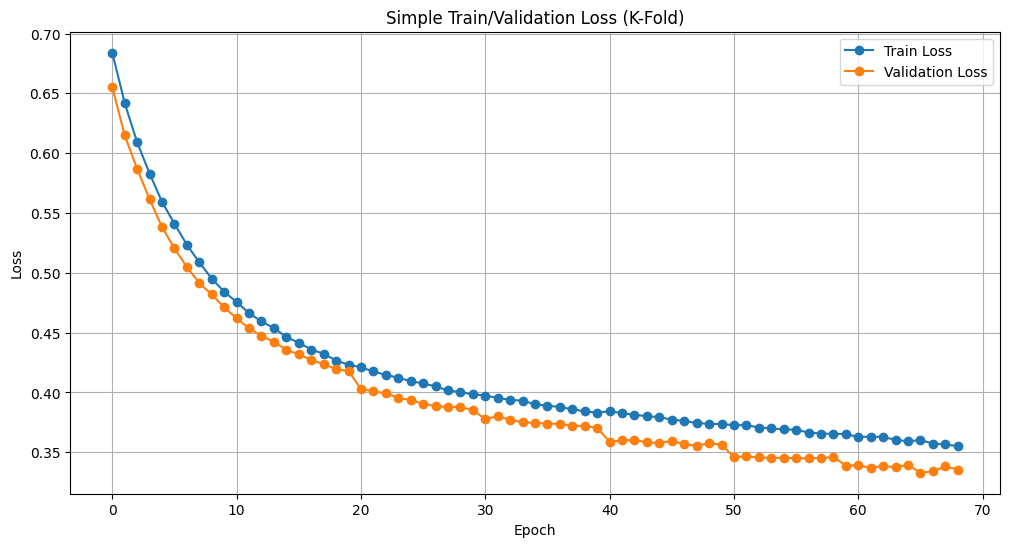

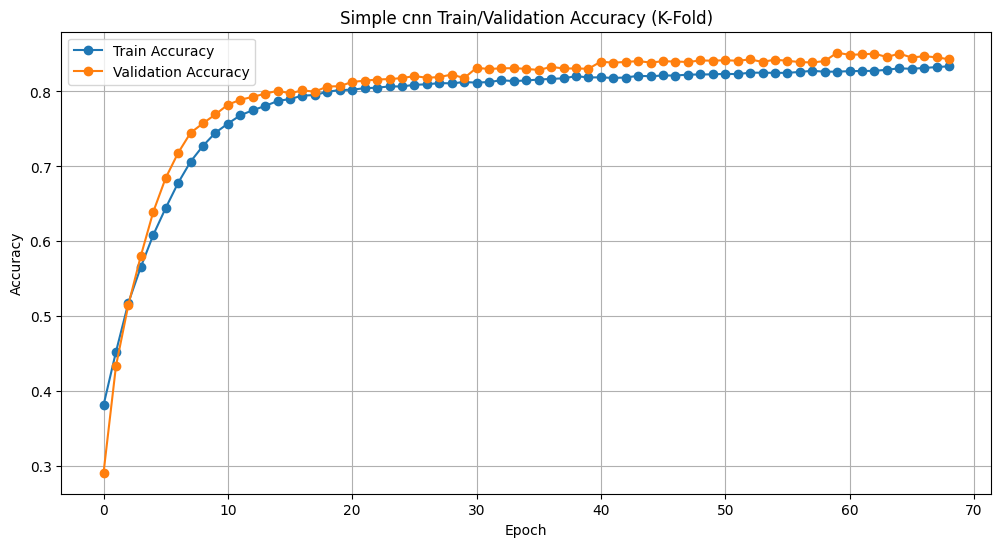

SIMPLE CNN K-Fold Cross-Validation 완료


In [30]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold 

# One-Hot Encoding 적용
train_df_encoded = train_df['genres'].str.get_dummies(sep=',')

# K-Fold 설정
num_folds = 8  # 폴드 수
# kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
kf = MultilabelStratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)

num_epochs = 10 # 일단 10번으로 테스트
train_loss_, val_loss_ = [], []     # 그래프용 로스저장
train_acc_, val_acc_ = [], []       # 그래프용 acc 저장

save_dir = "C:/sg0117/hallym/2024-dl-final/save_model_k-fold_simple/"

# K-Fold 루프 시작
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, train_df_encoded)):
    print(f"\nFold {fold + 1}/{num_folds} 시작...")

    # 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 데이터셋 및 데이터로더 생성
    train_dataset = MovieDataset(df=train_fold_df, transform=train_transform)
    val_dataset = MovieDataset(df=val_fold_df, transform=test_transform)
    print(train_dataset.__len__(), val_dataset.__len__())
    
    # pin_memory 쓰면 gpu cpu 이동 빨라짐
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

    best_val_loss = float("inf")    # loss 무한대
    best_val_acc = 0.0              # acc 0으로 설정
    patience = 3                    # Early stopping을 적용 에포크
    early_cnt = 0                   # 개선되지 않은 에포크 수를 기록
    early_stop = False              # d얼리스탑 플래그
    # 러닝레이트 스케줄러. loss 가 5번 동안 갱신되지 않으면 학습률 감소
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.5, patience=5)

    # 에포크 루프 시작
    for epoch in range(num_epochs):
        if early_stop:
            print(f"폴드 {fold + 1}: 조기 종료됨.")
            break

        print(f"Epoch {epoch+1}/{num_epochs} - Fold {fold + 1}")

        # 학습
        train_loss, train_preds, train_labels = train(model, train_loader, criterion, optimizer, device)
        train_loss_.append(train_loss)
        
        # train 임계값 0.4로 예측
        train_pred_binary = (train_preds > 0.4).int()
        train_label_binary = train_labels.int()
        train_acc = (train_pred_binary == train_label_binary).sum().item() / train_label_binary.numel()
        train_acc_.append(train_acc)
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        # 검증
        val_loss, val_preds, val_labels = validate(model, val_loader, criterion, device)
        val_loss_.append(val_loss)
        
        # val 임계값 0.4로 예측
        val_pred_binary = (val_preds > 0.4).int()
        val_label_binary = val_labels.int()
        val_acc = (val_pred_binary == val_label_binary).sum().item() / val_label_binary.numel()
        val_acc_.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

        # Best model 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_cnt = 0  # 최저 loss 갱신되면 카운트 초기화
            torch.save(model, save_dir + f"best_loss_simple_fold{fold+1}_model.pt")
            print(f"##########  Best Loss Model saved with loss: {best_val_loss:.4f}  ##########")
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }, save_dir + "best_loss_simple_fold_checkpoint.pth")
            print(f"##########  Best Loss Model saved checkpoin: {best_val_loss:.4f}  ##########")
        else:
            early_cnt += 1  # 갱신되지 않은 경우 카운트 증가

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model, save_dir + f"best_accuracy_simple_fold{fold+1}_model.pt")
            print(f"##########  Best Accuracy Model saved with accuracy: {best_val_acc:.4f}  ##########") 

        # 러닝 스케줄러
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  # ReduceLROnPlateau는 validation loss를 기준으로
        else:
            scheduler.step()

        # Early Stopping 확인
        if early_cnt >= patience:
            print(f"{patience} 에포크 동안 Loss 개선 없음. 조기 종료.")
            early_stop = True

# 성능 그래프 출력
plt.figure(figsize=(12, 6))
plt.plot(train_loss_, label="Train Loss", marker='o')
plt.plot(val_loss_, label="Validation Loss", marker='o')
plt.title("Simple Train/Validation Loss (K-Fold)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_acc_, label="Train Accuracy", marker='o')
plt.plot(val_acc_, label="Validation Accuracy", marker='o')
plt.title("Simple cnn Train/Validation Accuracy (K-Fold)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

print("SIMPLE CNN K-Fold Cross-Validation 완료")


Precision score : 0.5863857374392221
Recall score : 0.6205831903945112
F-score : 0.603


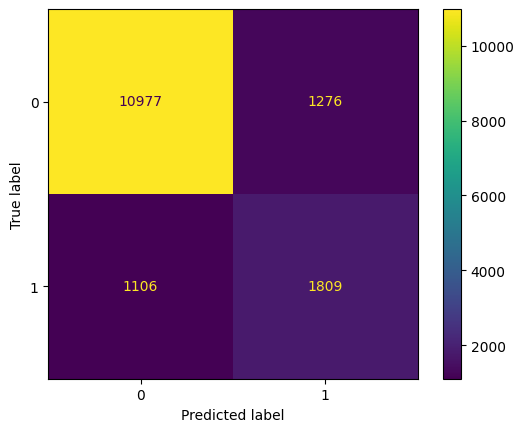

In [31]:
threshold = 0.4
from sklearn.metrics import ConfusionMatrixDisplay

outputs = []
v_loss = 0
tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for image, w2v, label in val_loader:
        image, w2v, label = image.float().to(device), w2v.float().to(device), label.float().to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            output = model(image, w2v)
            loss = criterion(output, label)

        output = output.detach().sigmoid()
        output = (output > threshold).long()
        label, output = label.cpu(), output.cpu()

        mcm = multilabel_confusion_matrix(label, output, samplewise=True)
        outputs.append(mcm)

        v_loss += loss.cpu().item()

        # tp += ((label == 1) & (output == 1)).float().sum()
        # tn += ((label == 0) & (output == 0)).float().sum()
        # fp += ((label == 0) & (label != output)).float().sum()
        # fn += ((label == 1) & (label != output)).float().sum()

# # 1. tp, tn, fp, fn을 직접 구하는 방법 
# precision = tp / (tp + fp)
# recall = tp / (tp + fn)
# f1 = 2 * (precision * recall) / (precision + recall)

# # 2. confusion matrix의 결과를 바로 사용하는 방법 (tn, fp, fn, tp)
# cm = [[tn, fp],
#       [fn, tp]]

conf = np.sum(np.concatenate(outputs), axis=0)
precision = conf[1, 1] / (conf[1, 1] + conf[0, 1])
recall = conf[1, 1] / (conf[1, 1] + conf[1, 0])
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision score : {precision}')
print(f'Recall score : {recall}')
print(f'F-score : {f1}')

disp = ConfusionMatrixDisplay(conf)
disp.plot()
plt.show()

In [34]:
def test(model, test_loader, threshold=0.4):
    outputs = []

    model.eval()
    with torch.no_grad():
        for image, w2v in tqdm(test_loader, desc='Test'):
            image, w2v = image.float().to(device), w2v.float().to(device)

            # Automatic Mixed Precision(AMP) 사용 (학습 속도, 메모리 절약)
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                output = model(image, w2v)

            output = output.detach().sigmoid()
            output = (output > threshold).long()  # threshold를 기준으로 0/1 판별
            outputs.append(output)

    outputs = torch.cat(outputs, dim=0).cpu().numpy()

    return outputs

Test: 100%|██████████| 315/315 [00:34<00:00,  9.05it/s]


In [ ]:
# Threshold  0.4 설정
from datetime import datetime

# "C:\sg0117\hallym\2024-dl-final\save_model_Add_LSTM\best_accuracy_model.pt"
# C:\sg0117\hallym\2024-dl-final\save_model_EfficentNet\241214_EfficinetNet_best_accuracy_model.pt
# C:\sg0117\hallym\2024-dl-final\save_model_k-fold_simple\best_loss_simple_fold8_model.pt

root_path = "C:/sg0117/hallym/2024-dl-final/"

dt = datetime.now()
ctime = dt.strftime('%m%d_%H%M')  # 현재 월/일_시/분 확인

model = torch.load(root_path + "save_model_k-fold_simple/best_loss_simple_fold8_model.pt", weights_only=False)  # save_dir + [file_name]
model = model.to(device)

threshold = 0.3
results = test(model, test_loader, threshold=threshold)

submission = pd.read_csv(root_path + 'sample_submission.csv')

submission.iloc[:, 1:] = results
submission.to_csv(save_dir + f'submission_simple-CNN_with_k-fold8_test-TH4_BEST_Loss_{ctime}.csv', index=False)